<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/06__Transfer_Learning_with_TensorFlow_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-05 07:40:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-05 07:40:23 (17.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

#Downloading and preprocessing the data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-05 07:40:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   140MB/s    in 9.8s    

2024-05-05 07:40:46 (158 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_f

In [5]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#Train a big model with transfer learning on 10% of 101 food classes

following modelling setup:

A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

Data augmentation built right into the model

A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model

A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

Categorical crossentropy as the loss function since we're dealing with more than two classes

The Adam optimizer with the default settings
Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weight_only=True, #save only the model weights
                                                       monitor="val-accuracy", # save the model weights which score the best validation accurac
                                                       save_best_only=True # only keep the best model weights on file (delete the rest)
                                                       )

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
#Create data augmentetion layer

data_augmentation=Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
])

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)  # augment images (only happens during training)
x=base_model(x,training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x=layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [10]:
#Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [11]:
#Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
#Fit the mode
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)), # evaluate on 15%
                                         callbacks=[checkpoint_callback]
                                         )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3680 - accuracy: 0.2754

237/237 [==============================] - 154s 605ms/step - loss: 3.3680 - accuracy: 0.2754 - val_loss: 2.4524 - val_accuracy: 0.4709
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1983 - accuracy: 0.4954

237/237 [==============================] - 105s 439ms/step - loss: 2.1983 - accuracy: 0.4954 - val_loss: 1.9949 - val_accuracy: 0.5283
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8191 - accuracy: 0.5645

237/237 [==============================] - 87s 364ms/step - loss: 1.8191 - accuracy: 0.5645 - val_loss: 1.8416 - val_accuracy: 0.5323
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6052 - accuracy: 0.6073

237/237 [==============================] - 80s 335ms/step - loss: 1.6052 - accuracy: 0.6073 - val_loss: 1.7508 - val_accuracy: 0.5498
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4580 - accuracy: 0.6446

237/237 [==============================] - 77s 323ms/step - loss: 1.4580 - accuracy: 0.6446 - val_loss: 1.7058 - val_accuracy: 0.5575


In [13]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 55s 70ms/step - loss: 1.5854 - accuracy: 0.5810


[1.585448980331421, 0.5810297131538391]

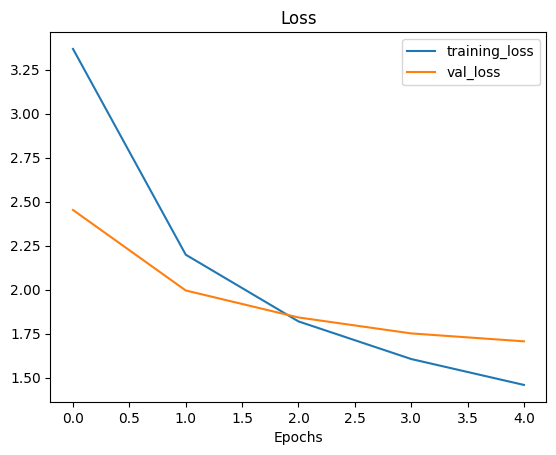

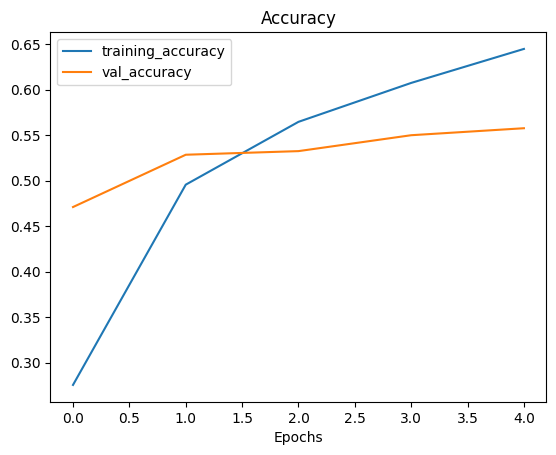

In [15]:
plot_loss_curves(history_all_classes_10_percent)